In [3]:
!pip install dask
!pip install numpy
!pip install pandas
!pip install pyarrow
!pip install plotly
!pip install nbformat
!pip show nbformat
!pip install seaborn
!pip install folium

Name: nbformat
Version: 5.10.4
Summary: The Jupyter Notebook format
Home-page: https://jupyter.org
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License

- Copyright (c) 2001-2015, IPython Development Team
- Copyright (c) 2015-, Jupyter Development Team

All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior writte

In [1]:
import sys
print(sys.executable)

c:\Users\atul1\Work\tools\Python3_12\python.exe


In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import numpy as np
import random
#https://simplemaps.com/data/us-cities

In [ ]:
raw_file_path = r"..\data\US_Accidents_March23.csv"
fl_data_file = r"..\data\state_wise_data\FL_org.csv"
ca_data_file = r"..\data\state_wise_data\CA_org.csv"
va_data_file = r"..\data\state_wise_data\VA_org.csv"
ny_data_file = r"..\data\state_wise_data\NY_org.csv"
chunk_size = 100000  # Adjust based on available memory
all_state_raw_data_file_frame = ""
all_state_cleaned_data_file_frame = ""

In [6]:
# Creating a DataFrame from the given data
# https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-detail.html?utm_source=chatgpt.com
USA_2023_POPULATION_DATA = {
    "State": [
        "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY",
        "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH",
        "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
    ],
    "Population": [
        3977628, 557899, 5848310, 2362124, 30519524, 4662926, 2894190, 819952, 552380, 18229883,
        8490546, 1141525, 1497384, 9844167, 5274945, 2476882, 2246209, 3509259, 3506600, 1146670,
        4818337, 5659598, 7925350, 4436981, 2259864, 4821686, 897161, 1497381, 2508220, 1150004,
        7280551, 1663024, 15611308, 8498868, 599192, 9207681, 3087217, 3401528, 10332678, 892124,
        4229354, 697420, 5555761, 22942176, 2484582, 532828, 6834154, 6164810, 1417859, 4661826, 454508
    ]
}

usa_2023_population_age_18_and_up_data_frame = pd.DataFrame(USA_2023_POPULATION_DATA)
display(usa_2023_population_age_18_and_up_data_frame.head(10))


,State,Population
0,AL,3977628
1,AK,557899
2,AZ,5848310
3,AR,2362124
4,CA,30519524
5,CO,4662926
6,CT,2894190
7,DE,819952
8,DC,552380
9,FL,18229883


In [8]:

def read_large_csv(file_path, chunk_size):
    """Reads a large CSV file in chunks and returns a generator of chunks."""
    return pd.read_csv(file_path, chunksize=chunk_size, low_memory=False)

def process_large_csv(file_path, chunk_size=100000):
    """Processes the large CSV file and returns the cleaned DataFrame."""
    df_combined = pd.DataFrame()

    for chunk in read_large_csv(file_path, chunk_size):
        df_combined = pd.concat([df_combined, chunk], ignore_index=True)

    return df_combined


def drop_columns(data_frame):
    cols_to_drop = ['ID', 'Source', 'End_Lat', 'End_Lng', 'Distance(mi)', 
                    'Description', 'Airport_Code', 'Pressure(in)', 
                    'Wind_Direction', 'Precipitation(in)', 
                    'Amenity','Give_Way', 'No_Exit', 'Traffic_Calming', 
                    'Turning_Loop', 'Nautical_Twilight', 'Astronomical_Twilight',
                    'Civil_Twilight','Airport_Code','Sunrise_Sunset'
                    ]
    return data_frame.drop(cols_to_drop, axis=1)


def split_and_save_by_state(data_frame, output_dir=r"..\data\state_wise_data"):
    """Splits data by state and saves it into separate CSV files."""
    os.makedirs(output_dir, exist_ok=True)

    for state, state_df in data_frame.groupby("State"):
        if (state == 'FL' or state == 'CA' or state == 'VA' or state == 'NY') :
            state_file = os.path.join(output_dir, f"{state}_org.csv")
            state_df.to_csv(state_file, index=False)
    print(f"Data saved for FA, CA, VA, NY \n ")

def save_cleaned_all_state_data(data_frame, output_dir=r"..\data\cleaned_raw_data"):
    os.makedirs(output_dir, exist_ok=True)
    filePath = os.path.join(output_dir, "cleaned_all_state_data.csv")

    data_frame.to_csv(filePath, index=False)
    print(f"Saved Cleaned all state Data  \n ")


def print_summary(data_frame):
    print("** Data Frame Info: \n")
    print(f"{data_frame.info()}")
    print("\n ** Data Frame description: \n")
    print(data_frame.describe(include="all"))
    print("\n The shape of data is:",(all_state_raw_data_file_frame.shape))
    print("\n Top 3 records \n")
    display(all_state_raw_data_file_frame.head(3))
    print(" \n Unique Source: ", all_state_raw_data_file_frame['Source'].unique())

def plot_histogram_state_vs_accident_count(data_frame):
    """Analyzes the state-wise accident count and plots a histogram."""
    state_counts = data_frame["State"].value_counts()
    
    print(f"\nNumber of unique states: {state_counts.count()}")

    # Plot histogram for state vs accident count
    plt.figure(figsize=(12, 6))
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))   
    state_counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.xlabel("State")
    plt.ylabel("Total Accidents")
    plt.title("Total Accidents by State")
    plt.xticks(rotation=90)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


def plot_histogram_weather_condition_vs_accident_count(data_frame):
    """Analyzes the state-wise accident count and plots a histogram."""
    weather_condition = data_frame["Weather_Condition"].value_counts()
    
    plt.figure(figsize=(25, 20))
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))   
    weather_condition.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.xlabel("Weather")
    plt.ylabel("Total Accidents")
    plt.title("Total Accidents by weather condition")
    plt.xticks(rotation=90)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def plot_us_map_accident_count(data_frame):
    state_counts = data_frame["State"].value_counts().reset_index()
    state_counts.columns = ["State", "Accidents"]

    fig = px.choropleth(
        state_counts, 
        locations="State", 
        locationmode="USA-states", 
        color="Accidents",
        color_continuous_scale="reds",
        title="Number of US Accidents for each State"
    )
    fig.update_layout(geo=dict(scope="usa"))
    fig.show()

def plot_histogram_street_vs_accident_count(data_frame):
    """Analyzes the state-wise accident count and plots a histogram."""
    weather_condition = data_frame["Street"].value_counts()
    
    plt.figure(figsize=(25, 20))
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))   
    weather_condition.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.xlabel("Street")
    plt.ylabel("Total Accidents")
    plt.title("Total Accidents by weather condition")
    plt.xticks(rotation=90)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def plot_histogram_top_20_citi_accident_count(data_frame, text=""):

    # Get the top 20 cities with the highest number of accidents
    top_cities = data_frame["City"].value_counts().sort_values()[-20:].reset_index()
    top_cities.columns = ["city", "number_of_accidents"]

    # Plot the bar chart
    plt.figure(figsize=(20,7))
    sns.barplot(x="city", y="number_of_accidents", hue="city", data=top_cities, palette='Set2', legend=False)  # ✅ FIXED
    plt.title(f"TOP 20 CITIES WITH HIGHEST NUMBER OF ACCIDENTS - {text}", fontsize=20)
    plt.xticks(rotation=40)
    plt.show()

def create_map(df_loc, zoom=6, tiles='OpenStreetMap'):
    """
    Generate a Folium Map with clustered markers of accident locations.
    Automatically centers the map based on available locations in the dataset.
    """
    # Compute the mean latitude and longitude for centering the map
    mean_lat = df_loc['Start_Lat'].mean()
    mean_lng = df_loc['Start_Lng'].mean()

    # Create the map centered on the computed mean location
    state_map  = folium.Map(location=[mean_lat, mean_lng], zoom_start=zoom, tiles=tiles)

    # Add marker clustering
    marker_cluster = MarkerCluster().add_to(state_map)

    # Iterate over the DataFrame rows and add each marker to the cluster
    for idx, row in df_loc.iterrows():
        folium.Marker(
            location=[row['Start_Lat'], row['Start_Lng']],
            popup=f"Lat, Lng: {row['Start_Lat']}, {row['Start_Lng']}"
        ).add_to(marker_cluster)

    return state_map
 
def plot_stacked_bar_chart(data_frame):
    """
    Plots a stacked bar chart showing the distribution of accident severity across states.
    """
    # Count the number of accidents by state and severity
    severity_counts = data_frame.groupby(["State", "Severity"]).size().unstack(fill_value=0)

    # Define colors for different severity levels
    severity_colors = {1: "#66c2a5", 2: "#fc8d62", 3: "#8da0cb", 4: "#e78ac3"}

    # Plot the stacked bar chart
    severity_counts.plot(kind="bar", stacked=True, figsize=(14, 6), color=[severity_colors[i] for i in severity_counts.columns])

    # Chart formatting
    plt.title("Accident Severity Distribution Across States", fontsize=14)
    plt.xlabel("State", fontsize=12)
    plt.ylabel("Number of Accidents", fontsize=12)
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.legend(title="Severity Level")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.show()


# accedent_data_frame
def plot_stacked_bar_chart(accedent_data_frame, population_data_frame):

    # Count accidents per state per severity level
    severity_counts = accedent_data_frame.groupby(["State", "Severity"]).size().unstack(fill_value=0)
    
    # Merge with population data
    merged_df = population_data_frame.merge(severity_counts, on="State", how="left").fillna(0)
    
    # Define colors for severity levels
    severity_colors = {1: "#a6cee3", 2: "#1f78b4", 3: "#b2df8a", 4: "#33a02c"}

    # Plot stacked bar chart
    ax = merged_df.set_index("State")[sorted(severity_counts.columns)].plot(
        kind="bar", stacked=True, figsize=(14, 7), color=[severity_colors[s] for s in sorted(severity_counts.columns)]
    )

    # Labels and title
    plt.xlabel("State")
    plt.ylabel("Number of Accidents")
    plt.title("Stacked Bar Chart of Accidents per State by Severity Level")
    plt.xticks(rotation=45, ha="right")
    
    # Add legend
    plt.legend(title="Severity Level", loc="upper right")

    # Show plot
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_bubble_chart(accedent_data_frame, population_data_frame):
    # Aggregate accident count and average severity per state
    accident_summary = accedent_data_frame.groupby("State").agg(
        Accidents=("State", "count"),
        Avg_Severity=("Severity", "mean")
    ).reset_index()

    # Merge with population data
    merged_df = pd.merge(accident_summary, population_data_frame, on="State")

    # Normalize population size for better bubble visualization
    pop_scaled = merged_df["Population"] / 50000  # Adjusting scale for better visibility

    # Create Bubble Chart
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        merged_df["Population"], 
        merged_df["Accidents"], 
        s=pop_scaled,  # Bubble size based on population
        c=merged_df["Avg_Severity"],  # Color based on severity
        cmap="Reds", 
        alpha=0.7,
        edgecolors="k"
    )

    # Add state labels on each bubble
    for i, row in merged_df.iterrows():
        plt.text(row["Population"], row["Accidents"], row["State"], fontsize=10, ha='center', va='center', color="black")

    # Add color bar for severity
    cbar = plt.colorbar(scatter)
    cbar.set_label("Average Severity (1=Low, 4=High)")

    # Labels and title
    plt.xlabel("State Population")
    plt.ylabel("Number of Accidents")
    plt.title("Bubble Chart of Accidents vs. Population (Scaled by Population & Colored by Severity)")

    # Grid for better readability
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show plot
    plt.show()


def plot_population_vs_accident_percentage(accedent_data_frame, population_data_frame):

    # Count total accidents per state and calculate severity average
    accident_summary = accedent_data_frame.groupby("State").agg(
        Accidents=("State", "count"),
        Avg_Severity=("Severity", "mean")
    ).reset_index()

    # Merge with population data
    merged_df = pd.merge(accident_summary, population_data_frame, on="State")

    # Calculate percentage of population involved in accidents
    merged_df["Accident_Percentage"] = (merged_df["Accidents"] / merged_df["Population"]) * 100

    # Create Scatter Plot
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        merged_df["Accident_Percentage"], 
        merged_df["Avg_Severity"], 
        s=merged_df["Population"] / 50000,  # Bubble size based on population
        c=merged_df["Avg_Severity"],  # Color based on severity
        cmap="Reds", 
        alpha=0.7,
        edgecolors="k"
    )

    # Add state labels to each point
    for i, row in merged_df.iterrows():
        plt.text(row["Accident_Percentage"], row["Avg_Severity"], row["State"], fontsize=10, ha='right', va='center', color="black")

    # Add color bar for severity
    cbar = plt.colorbar(scatter)
    cbar.set_label("Average Severity (1=Low, 4=High)")

    # Labels and title
    plt.xlabel("Accident Percentage of State Population")
    plt.ylabel("Average Severity of Accidents")
    plt.title("Scatter Plot: Accident Percentage vs. Severity per State")

    # Grid for better readability
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show plot
    plt.show()



def plot_paginated_accident_percentage_improved(accident_data_frame, population_data_frame, states_per_page=4):

    # Aggregate accident count per state and severity
    accident_summary = accident_data_frame.groupby(["State", "Severity"]).size().unstack(fill_value=0)

    # Merge with population data
    merged_df = population_data_frame.merge(accident_summary, on="State", how="left").fillna(0)

    # Calculate accident percentage per severity level
    for severity in sorted(accident_summary.columns):
        merged_df[f"Severity_{severity}_Percentage"] = (merged_df[severity] / merged_df["Population"]) * 100

    # Sort states by population (descending)
    merged_df = merged_df.sort_values(by="Population", ascending=False)

    # Define severity colors
    severity_colors = {1: "#a6cee3", 2: "#1f78b4", 3: "#b2df8a", 4: "#33a02c"}

    # Paginate the states into batches
    total_states = len(merged_df)
    for start in range(0, total_states, states_per_page):
        end = min(start + states_per_page, total_states)
        subset_df = merged_df.iloc[start:end]

        # Determine subplot grid size
        num_states = len(subset_df)
        cols = 2  # Maximum 2 columns for better readability
        rows = int(np.ceil(num_states / cols))  # Auto-adjust row count

        # Adjust figure size dynamically
        fig_height = max(4, rows * 2.5)  # Ensure proper spacing
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, fig_height))
        axes = np.array(axes).reshape(-1)  # Flatten for easy indexing

        # Generate bar plots for each state
        for idx, row in enumerate(subset_df.itertuples()):
            state = row.State
            population = row.Population
            severity_percentages = [getattr(row, f"Severity_{s}_Percentage") for s in sorted(accident_summary.columns)]

            # Plot bars
            bars = axes[idx].bar(
                sorted(accident_summary.columns),
                severity_percentages,
                color=[severity_colors[s] for s in sorted(accident_summary.columns)]
            )

            # Adjust y-axis limits to ensure no overlap
            max_percentage = max(severity_percentages) if severity_percentages else 0
            axes[idx].set_ylim(0, max_percentage * 1.3)  # Add space above bars

            # Add title with population info, ensuring no overlap with bars
            axes[idx].text(0.5, 1.15, f"{state}\nPop: {population:,}", fontsize=10, fontweight="bold",
                           ha='center', va='top', transform=axes[idx].transAxes)

            axes[idx].set_xlabel("Severity Level")
            axes[idx].set_ylabel("Accident % of Population")
            axes[idx].set_xticks(sorted(accident_summary.columns))

            # Add percentage annotations on bars with dynamic vertical placement
            for bar, percent in zip(bars, severity_percentages):
                height_adjustment = max_percentage * 0.05  # Adjust placement dynamically
                axes[idx].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + height_adjustment,
                               f"{percent:.2f}%", ha='center', va='bottom', fontsize=8, color="black")

        # Hide any unused subplots (if fewer states than grid size)
        for i in range(idx + 1, len(axes)):
            fig.delaxes(axes[i])

        # Show the current page of subplots
        plt.suptitle(f"Accident Percentage by Severity Level per State (Sorted by Population)\nPage {start // states_per_page + 1}", 
                     fontsize=14, fontweight="bold")
        plt.tight_layout()  # Ensures spacing is adjusted properly
        plt.show()


In [9]:
all_state_raw_data_file_frame = process_large_csv(raw_file_path, chunk_size)

In [10]:
print("Raw Data Summary. \n")
print_summary(all_state_raw_data_file_frame)


Raw Data Summary. 

** Data Frame Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day


 
 Unique Source:  ['Source2' 'Source3' 'Source1']


 *****************  Exploration on RAW Data  ************** 
 
 ********************************************************** 
 

Number of unique states: 49


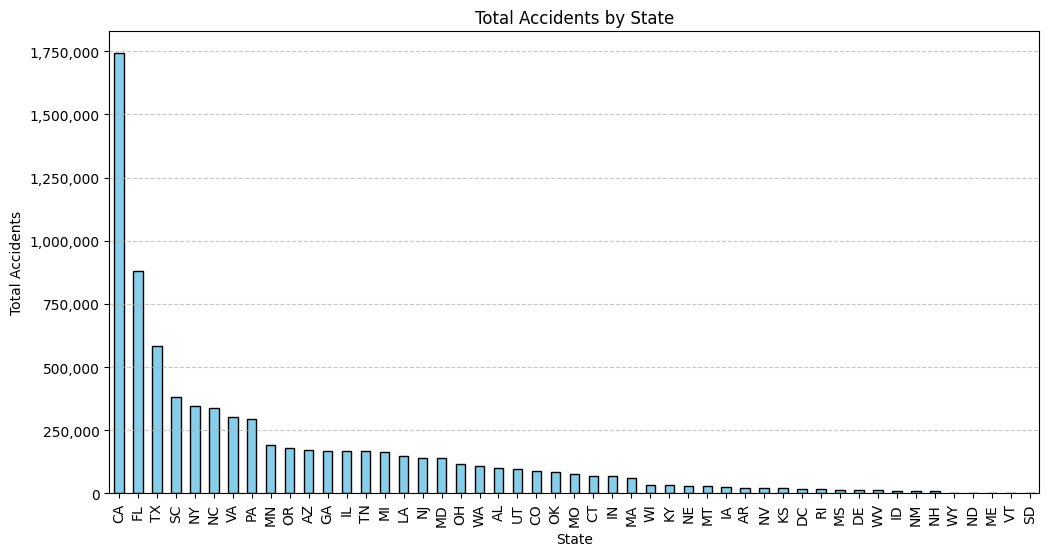

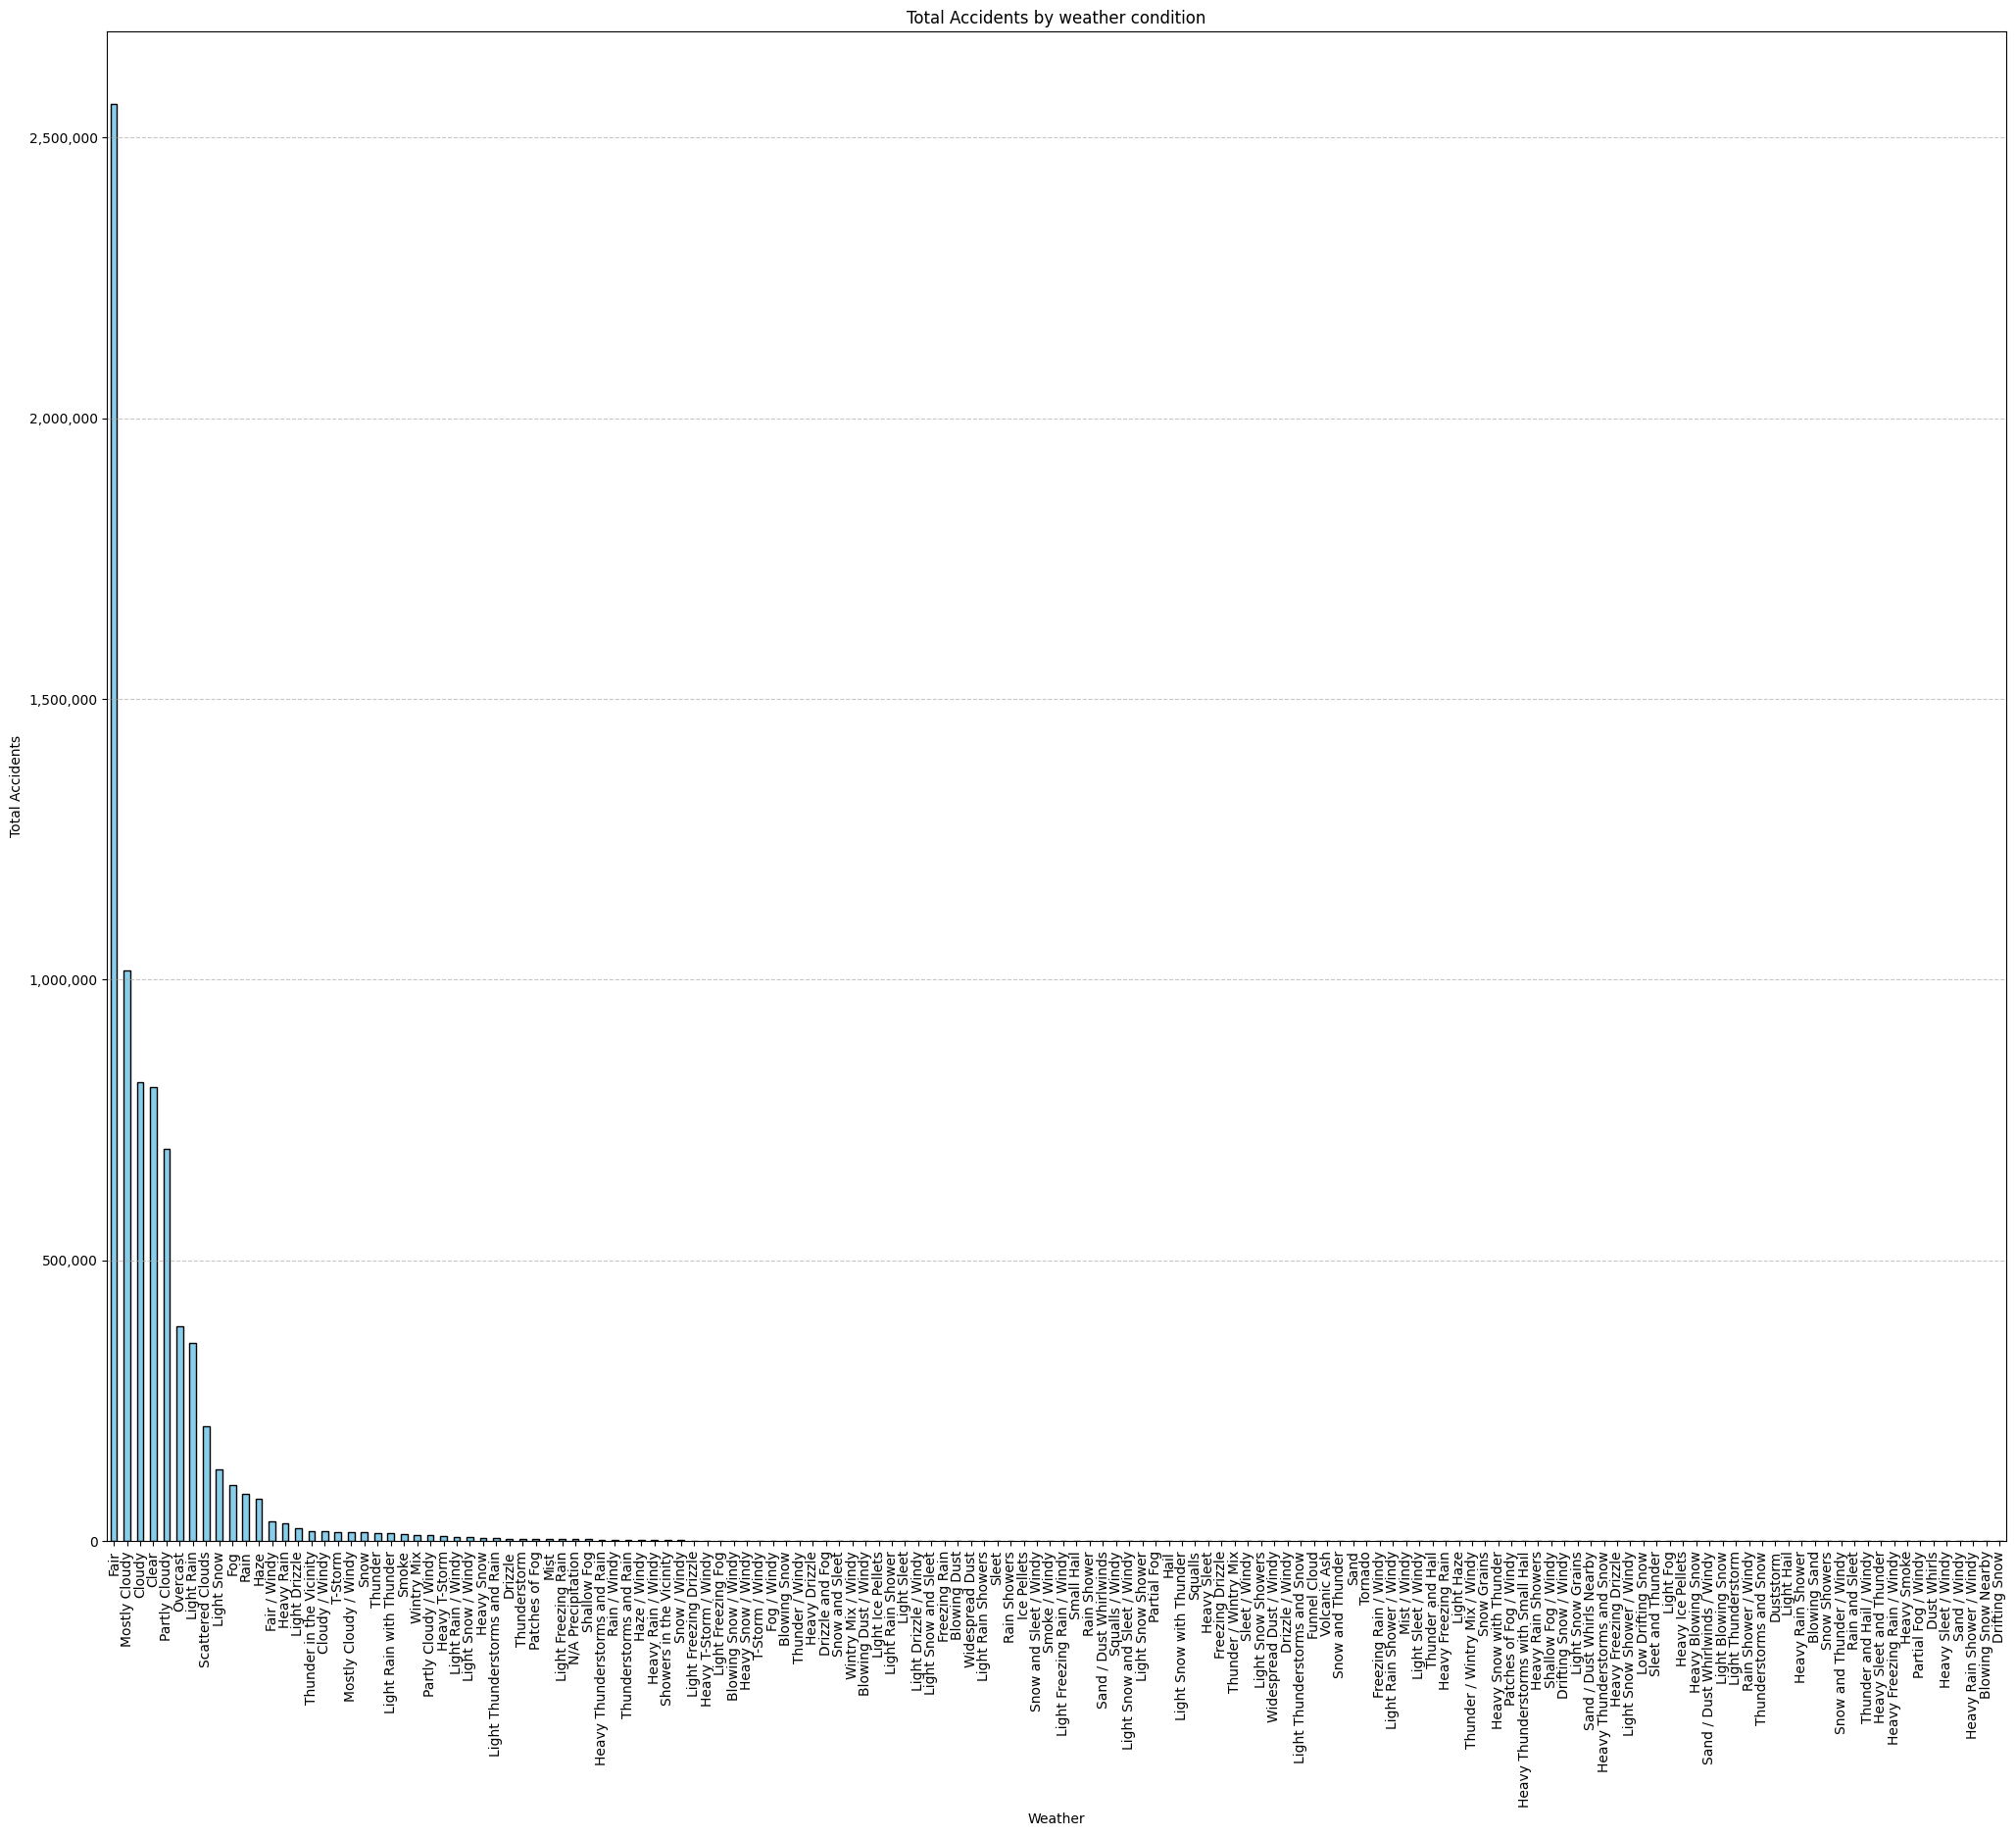

In [11]:
print(" *****************  Exploration on RAW Data  ************** \n ")
print(" ********************************************************** \n ")
plot_histogram_state_vs_accident_count(all_state_raw_data_file_frame)
plot_us_map_accident_count(all_state_raw_data_file_frame)
plot_histogram_weather_condition_vs_accident_count(all_state_raw_data_file_frame)

In [12]:
print(" *****************  Starting Data Cleanup  **************")
all_state_raw_data_file_frame = all_state_raw_data_file_frame[all_state_raw_data_file_frame["Source"].str.lower() == "source1"]
all_state_raw_data_file_frame = drop_columns(all_state_raw_data_file_frame)
print('Shape: ',all_state_raw_data_file_frame.shape[0])
print("\n Dataframe after droping roes: \n",all_state_raw_data_file_frame.info())

missing_data = pd.DataFrame(all_state_raw_data_file_frame.isnull().sum()).reset_index()
missing_data.columns = ['Feature', 'Missing_Percent(%)']
missing_data['Missing_Percent(%)'] = missing_data['Missing_Percent(%)'].apply(lambda x: x / all_state_raw_data_file_frame.shape[0] * 100)
missing_data.loc[missing_data['Missing_Percent(%)']>0,:]

all_state_raw_data_file_frame = all_state_raw_data_file_frame.drop(['Wind_Chill(F)'], axis=1)
print("\n Dataframe after droping roes: \n",all_state_raw_data_file_frame.info())

print("\n Shape:", all_state_raw_data_file_frame.shape[0])

all_state_raw_data_file_frame = all_state_raw_data_file_frame.dropna(subset=['City','Zipcode','Street',
                       'Zipcode','County','Timezone','Weather_Timestamp'])
print(" \n Shape:", all_state_raw_data_file_frame.shape[0])
print("Is Null Sum:\n ",all_state_raw_data_file_frame.isnull().sum())
print(all_state_raw_data_file_frame.shape)
all_state_raw_data_file_frame.dropna(inplace = True)
print(all_state_raw_data_file_frame.shape)
#split_and_save_by_state(all_state_raw_data_file_frame)
#save_cleaned_all_state_data(all_state_raw_data_file_frame)



 *****************  Starting Data Cleanup  **************
Shape:  4325632
<class 'pandas.core.frame.DataFrame'>
Index: 4325632 entries, 3402762 to 7728393
Data columns (total 27 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Time         object 
 2   End_Time           object 
 3   Start_Lat          float64
 4   Start_Lng          float64
 5   Street             object 
 6   City               object 
 7   County             object 
 8   State              object 
 9   Zipcode            object 
 10  Country            object 
 11  Timezone           object 
 12  Weather_Timestamp  object 
 13  Temperature(F)     float64
 14  Wind_Chill(F)      float64
 15  Humidity(%)        float64
 16  Visibility(mi)     float64
 17  Wind_Speed(mph)    float64
 18  Weather_Condition  object 
 19  Bump               bool   
 20  Crossing           bool   
 21  Junction           bool   
 22  Railway            bool   
 23  Roundab

In [13]:
all_state_cleaned_data_file_frame = all_state_raw_data_file_frame
print("\n Dataframe after adding new columns roes: \n",all_state_cleaned_data_file_frame.info())
print(all_state_cleaned_data_file_frame.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 4065577 entries, 3402762 to 7728393
Data columns (total 26 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Time         object 
 2   End_Time           object 
 3   Start_Lat          float64
 4   Start_Lng          float64
 5   Street             object 
 6   City               object 
 7   County             object 
 8   State              object 
 9   Zipcode            object 
 10  Country            object 
 11  Timezone           object 
 12  Weather_Timestamp  object 
 13  Temperature(F)     float64
 14  Humidity(%)        float64
 15  Visibility(mi)     float64
 16  Wind_Speed(mph)    float64
 17  Weather_Condition  object 
 18  Bump               bool   
 19  Crossing           bool   
 20  Junction           bool   
 21  Railway            bool   
 22  Roundabout         bool   
 23  Station            bool   
 24  Stop               bool   
 25  Traffic_Signal   

 *****************  Exploration on Cleanedup Data All State  ************** 
 
 **************************************************************** 
 


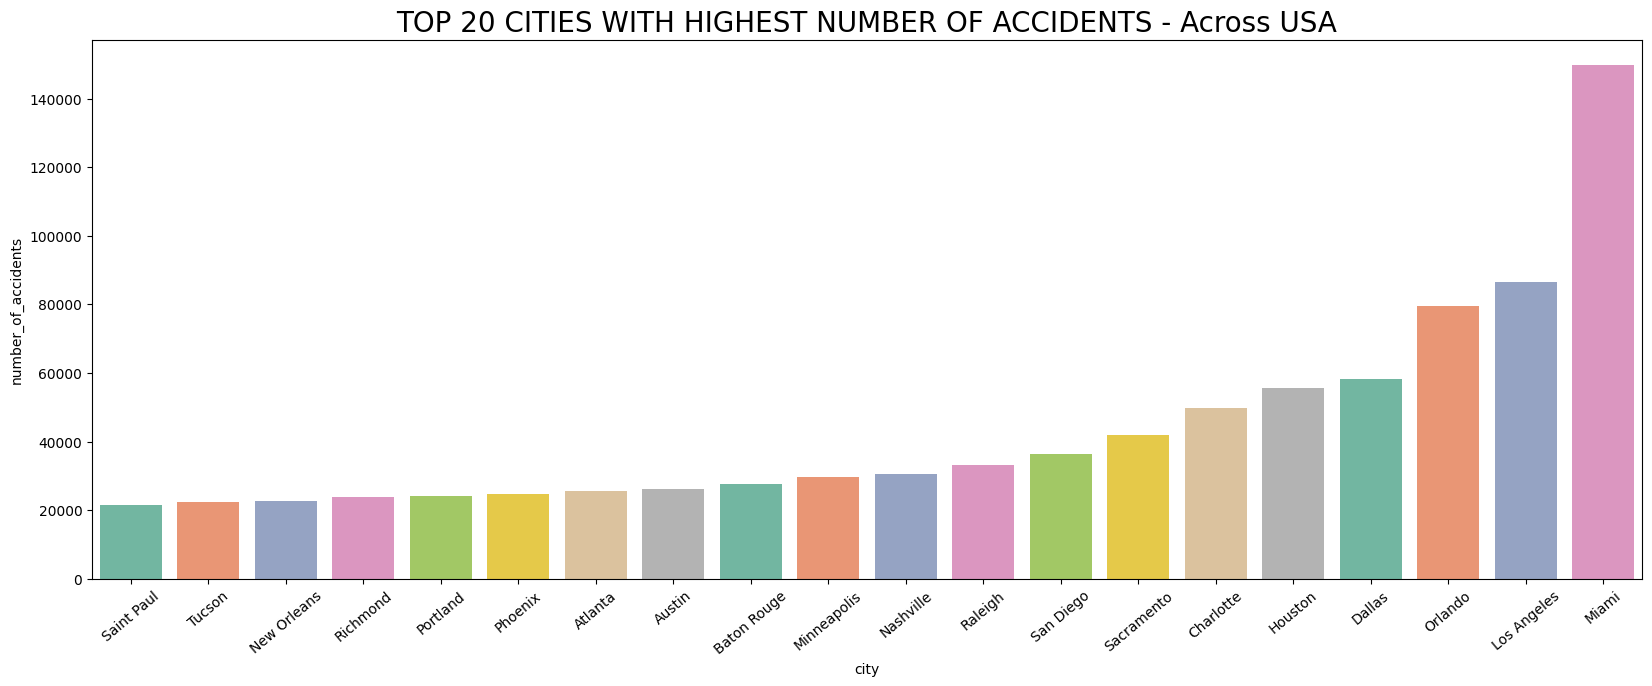


Number of unique states: 49


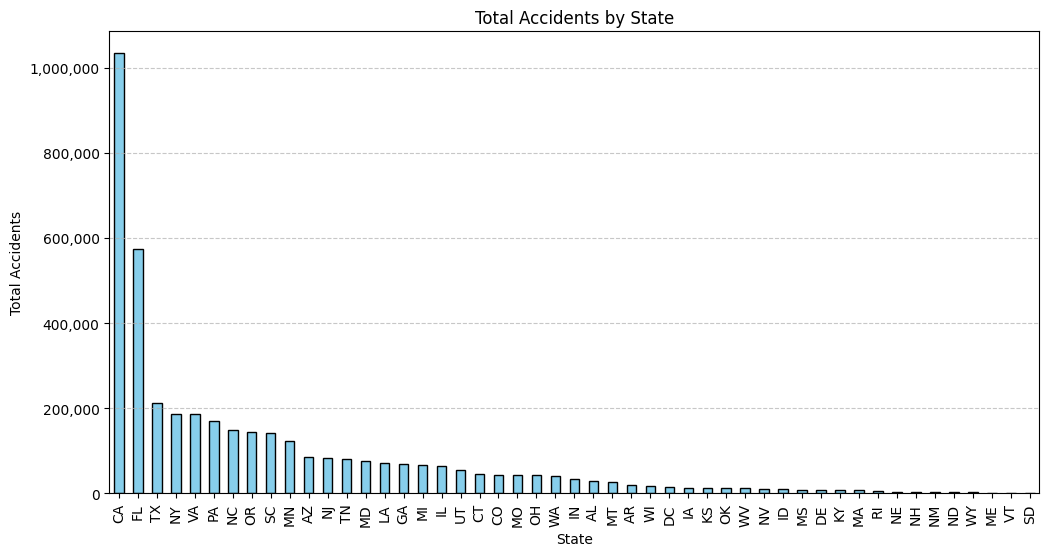

In [14]:
print(" *****************  Exploration on Cleanedup Data All State  ************** \n ")
print(" **************************************************************** \n ")
plot_histogram_top_20_citi_accident_count(all_state_cleaned_data_file_frame, 'Across USA')
plot_us_map_accident_count(all_state_cleaned_data_file_frame)
plot_histogram_state_vs_accident_count(all_state_cleaned_data_file_frame)
